In [2]:
import os
import random
import pandas as pd

def list_python_files(folder_path):
    """List all Python files in the given folder."""
    return [f for f in os.listdir(folder_path) if f.endswith('.py')]

def make_small_changes(code):
    """Introduce small modifications to simulate plagiarism."""
    lines = code.split("\n")
    if len(lines) > 2:
        random.shuffle(lines[:2])  # Shuffle first two lines
    code = "\n".join(lines)
    return code.replace("=", " = ")  # Add minor spacing variation

def create_dataset(folder_path, output_csv="plagiarism_dataset.csv"):
    """Generate a dataset of plagiarized and non-plagiarized code pairs and save plagiarized files."""
    python_files = list_python_files(folder_path)
    random.shuffle(python_files)

    num_samples = len(python_files) // 2  # 50% sampling
    sampled_files = python_files[:num_samples]
    remaining_files = python_files[num_samples:]

    dataset = []
    plagiarized_versions = {}

    # Create plagiarized pairs (label 1) and save modified files
    for filename in sampled_files:
        original_path = os.path.join(folder_path, filename)
        with open(original_path, "r", encoding="utf-8") as f:
            original_code = f.read()

        modified_code = make_small_changes(original_code)

        plagiarized_filename = f"plagiarized_{filename}"
        plagiarized_path = os.path.join(folder_path, plagiarized_filename)

        # Save modified file in the same folder
        with open(plagiarized_path, "w", encoding="utf-8") as f:
            f.write(modified_code)

        plagiarized_versions[plagiarized_filename] = modified_code

        dataset.append((filename, plagiarized_filename, 1))

    # Create non-plagiarized pairs (label 0)
    for filename in remaining_files:
        random_original = random.choice(list(plagiarized_versions.keys()))
        dataset.append((filename, random_original, 0))

    # Save dataset as CSV
    df = pd.DataFrame(dataset, columns=["code1", "code2", "label"])
    df.to_csv(output_csv, index=False)
    print(f"Dataset saved to {output_csv}")
    print(f"Plagiarized files saved in {folder_path}")

# Example usage:
create_dataset("/content/drive/MyDrive/Data_code/data_code")


Dataset saved to plagiarism_dataset.csv
Plagiarized files saved in /content/drive/MyDrive/Data_code/data_code


In [3]:
import os
import torch
import pandas as pd
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Load dataset CSV
df = pd.read_csv("plagiarism_dataset.csv")

# Folder where Python code files are stored
CODE_FOLDER = "/content/drive/MyDrive/Data_code/data_code"

def read_file_content(filename):
    """Reads the content of a Python file safely."""
    file_path = os.path.join(CODE_FOLDER, filename)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return ""

# Convert dataset into JSON format with actual code content
dataset_json = [
    {"text": f"Code 1:\n{read_file_content(row['code1'])}\n\nCode 2:\n{read_file_content(row['code2'])}",
     "label": row["label"]}
    for _, row in df.iterrows()
]

# Save dataset as JSON for reference
with open("plagiarism_dataset.json", "w") as f:
    json.dump(dataset_json, f, indent=4)

# Load CodeGPT tokenizer
MODEL_NAME = "microsoft/CodeGPT-small-py"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class CodePlagiarismDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.texts = [data["text"] for data in dataset]
        self.labels = [data["label"] for data in dataset]
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Tokenize dataset
train_size = int(0.8 * len(dataset_json))
train_dataset = CodePlagiarismDataset(dataset_json[:train_size], tokenizer)
val_dataset = CodePlagiarismDataset(dataset_json[train_size:], tokenizer)

# Load pre-trained CodeGPT model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    seed=42,
)

# Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Fine-tune the model
train_result = trainer.train()

# Save the fine-tuned model
model.save_pretrained("codegpt-plagiarism-detector")
tokenizer.save_pretrained("codegpt-plagiarism-detector")
print("Fine-tuning complete. Model saved to 'codegpt-plagiarism-detector'.")

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Extract training history
logs = trainer.state.log_history
train_losses = [entry["loss"] for entry in logs if "loss" in entry]
val_losses = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]



tokenizer_config.json:   0%|          | 0.00/175 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/865k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/424k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/CodeGPT-small-py and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-2f2be19b4807>:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zda23m015 (iitmz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.763300,0.482665
2,0.685500,0.789839
3,0.506100,1.235411
4,0.387300,1.610100
5,0.258900,1.186561
6,0.287900,3.142761
7,0.165400,3.019579
8,0.190300,4.002216
9,0.078700,3.455704
10,0.048900,3.774096


Fine-tuning complete. Model saved to 'codegpt-plagiarism-detector'.


Evaluation Results: {'eval_loss': 3.7740960121154785, 'eval_runtime': 5.4723, 'eval_samples_per_second': 29.604, 'eval_steps_per_second': 3.838, 'epoch': 10.0}


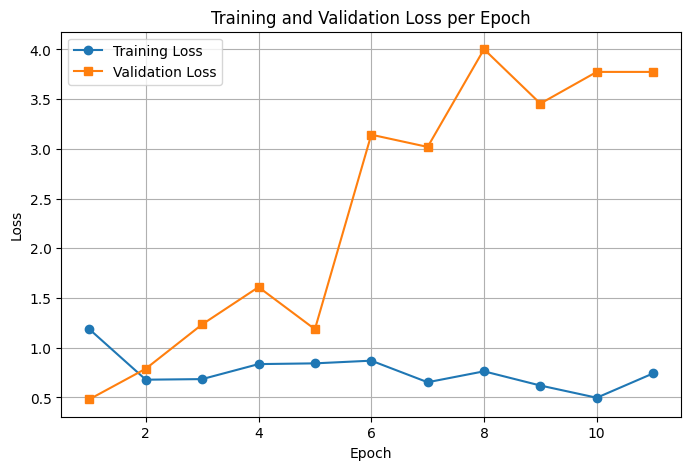

In [4]:
import matplotlib.pyplot as plt


logs = trainer.state.log_history

# Collect training losses at epoch level
train_losses = [entry["loss"] for entry in logs if "loss" in entry]
val_losses = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]

# Ensure same number of epochs for training and validation loss
num_epochs = min(len(train_losses), len(val_losses))
train_losses = train_losses[:num_epochs]
val_losses = val_losses[:num_epochs]

# Plot training and validation loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

In [6]:
import os
import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define paths
MODEL_PATH = "codegpt-plagiarism-detector"  # Path to fine-tuned model
TEST_CSV = "plagiarism_dataset.csv"  # Test dataset
CODE_FOLDER = "/content/drive/MyDrive/Data_code/data_code"  # Folder containing Python files

# Load fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model.eval()  # Set model to evaluation mode

def read_file_content(filename):
    """Reads and returns the content of a Python file."""
    file_path = os.path.join(CODE_FOLDER, filename)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return ""

def predict_plagiarism(code1, code2):
    """Predicts plagiarism between two pieces of code."""
    text = f"Code 1:\n{code1}\n\nCode 2:\n{code2}"
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    prediction = torch.argmax(outputs.logits, dim=1).item()
    return prediction  # 1 = Plagiarized, 0 = Not Plagiarized

# Load test dataset
df = pd.read_csv(TEST_CSV)
df["predicted_label"] = df.apply(
    lambda row: predict_plagiarism(read_file_content(row["code1"]), read_file_content(row["code2"])), axis=1
)

# Calculate evaluation metrics
y_true = df["label"].tolist()  # Ground truth
y_pred = df["predicted_label"].tolist()  # Model predictions

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Save results
df.to_csv("plagiarism_predictions.csv", index=False)
print("Predictions saved to 'plagiarism_predictions.csv'.")


Accuracy: 0.8391
Precision: 0.7585
Recall: 0.9950
F1 Score: 0.8608
Predictions saved to 'plagiarism_predictions.csv'.
